### Trading pairs
Trading pairs is a simple statistical arbitrage strategy that creates a market-neutral portfolio and tries to exploit market inefficieny in two highly correlated assets. The idea is to short one of the assets if it is overvalued relative to the second asset and simultaneously enter a long position in the other asset.

In [1]:
import sys
sys.path.append("../TradingSystem") # go to parent dir

In [2]:
# Ignore panda warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import yfinance as yf
import numpy as np

In [3]:
# Download financial data for a variety of
# cryptocurrencies and banks

crypto = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD', 'BSV-USD','DASH-USD']
bank = ['JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'DB']
tickers = crypto + bank
startDate = '2021-01-01'
endDate = '2023-10-31'

dataMap = {}
for ticker in tickers:
    dataMap[ticker]= yf.download(ticker, start=startDate, end=endDate, progress = False)

In [4]:
 #Clean the data
totalTime = (pd.to_datetime(endDate) -
                      pd.to_datetime(startDate)).days
cleanData = {}
validTickers = []
dateRange = pd.date_range(start=startDate, end=endDate, freq='D')
for ticker, df in dataMap.items():
    if df is None or len(df) < (totalTime / 2):
        continue

    # Filter and clean the dataframe
    df = df[['Adj Close']].iloc[-totalTime:].copy()
    df = df.reindex(dateRange)
    df['Adj Close'] = df['Adj Close'].replace([np.inf, -np.inf], np.nan)
    df['Adj Close'] = df['Adj Close'].interpolate(method='linear')
    df['Adj Close'].fillna(method='pad', inplace=True)
    df['Adj Close'].fillna(method='bfill', inplace=True)

    # Calculate log returns
    df['log return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
    df['log return'] = df['log return'].replace([np.inf, -np.inf], np.nan)
    df['log return'].fillna(0, inplace=True)
   
    # Ensure no NaN or infinite values in 'Adj Close' and 'log return'
    assert not df['Adj Close'].isnull().any() and not df['log return'].isnull().any()
    assert not np.any(np.isinf(df['Adj Close'])) and not np.any(np.isinf(df['log return']))

    # Store cleaned data and log returns in cleanData dictionary
    cleanData[ticker] = df
    validTickers.append(ticker)


    




### Cointegration
Let $X_t$ be a stochastic process and $F_X(x_1,\ldots,x_n)$ be the cumulative distribution function. The process is called {\em stationary} if 
\begin{equation}
    F_X(x_{t_1+\tau},\ldots, x_{t_n+\tau}) =  F_X(x_{t_1},\ldots, x_{t_n}) \forall t_1,\ldots,t_n,\tau ,n.
\end{equation}
For a stationary the mean $E(X_t)=\mu$ is time-independent.
(Connection to dynamical systems: Stationary processes are closely related to being measure preserving for the shift map. See http://galton.uchicago.edu/~lalley/Courses/381/ErgodicTheorem.pdf for a dicussion. )
One can then similarly define ergodic stochastic processes. We will not do this here but instead note that if a process is ergodic and stationary, then 
\begin{equation}
\dfrac{1}{T}\int_{i=1}^n X_t(\omega) = \mu.
\end{equation}
(A restatement of Birkhoffs ergodic theorem: Time-average equals space-average)

In particular, ergodic and stationary processes are mean-reverting, i.e. the time series eventually returns to the mean.

### Testing for cointegration

For our trading of pair strategy we will assume an autogregressive-model $AR(p)$ for $X_t$ , i.e.
\begin{equation}
   y_t = \alpha_1+\alpha_2t +\sum_{i=1}^p \beta_i y_{t-i}+\epsilon_t.
\end{equation}
By taking successive differences this can be written as 

\begin{equation}
    \Delta y_t = \alpha_1+\alpha_2t +\gamma \Delta y_{t-1}+\sum_{i=1}^p \beta_i \Delta y_{t-i}+\epsilon_t,
\end{equation}
where $\Delta y_k = y_k - y_{k-1}$.

One can show that an $AR(p)$ model is ergodic and stationary if and only if it has no root of unity, i.e. $\gamma=0$.
The Augmented Dickey-Fuller(ADF) test is a hypothesis test with
$H_0: \gamma=0.$


To test two time seris $x_t, y_t$ for cointegration we use the Engle and Granger 2-step approach. 
 - Test that $x_t$ and $y_t$ are non-stationary using the ADF test.
 - Regress $y_t$ on $x_t$ and use a $t$-test to tset for cointegration.



In [5]:
from statsmodels.tsa.stattools import coint
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from itertools import combinations


# Compute p values for the Engle-Granger test

n = len(tickers)

pThreshold = 0.001
# Extract 'log returns' prices into a matrix (each column is a time series)
adjCloseMatrix = np.column_stack(
    [cleanData[ticker]['log return'].values for ticker in validTickers])
pValMatrix = np.ones((n, n))
# Calculate cointegration p-values for unique pair combinations
for i, j in combinations(range(n), 2):
    result = coint(adjCloseMatrix[:, i], adjCloseMatrix[:, j])
    pValMatrix[i, j] = result[1]
pairs = [(tickers[i], tickers[j], pValMatrix[i, j])
            for i, j in zip(*np.where(pValMatrix < pThreshold))]



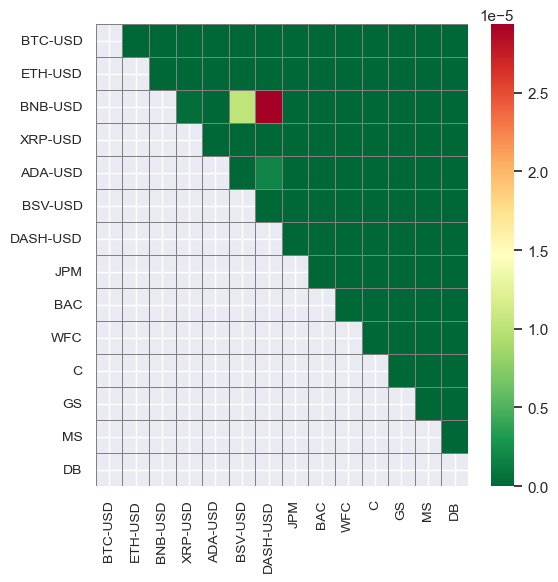

In [6]:

# Draw a heatmap showing all pairs whose time series is cointegrated and if so, how small the p-Value is
plt.figure(figsize=(6, 6))
heatmap = sns.heatmap(pValMatrix, xticklabels=cleanData.keys(),
                      yticklabels=cleanData.keys(), cmap='RdYlGn_r',
                      mask=(pValMatrix > (pThreshold)),
                      linecolor='gray', linewidths=0.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), size=10)
heatmap.set_yticklabels(heatmap.get_yticklabels(), size=10)
plt.show()

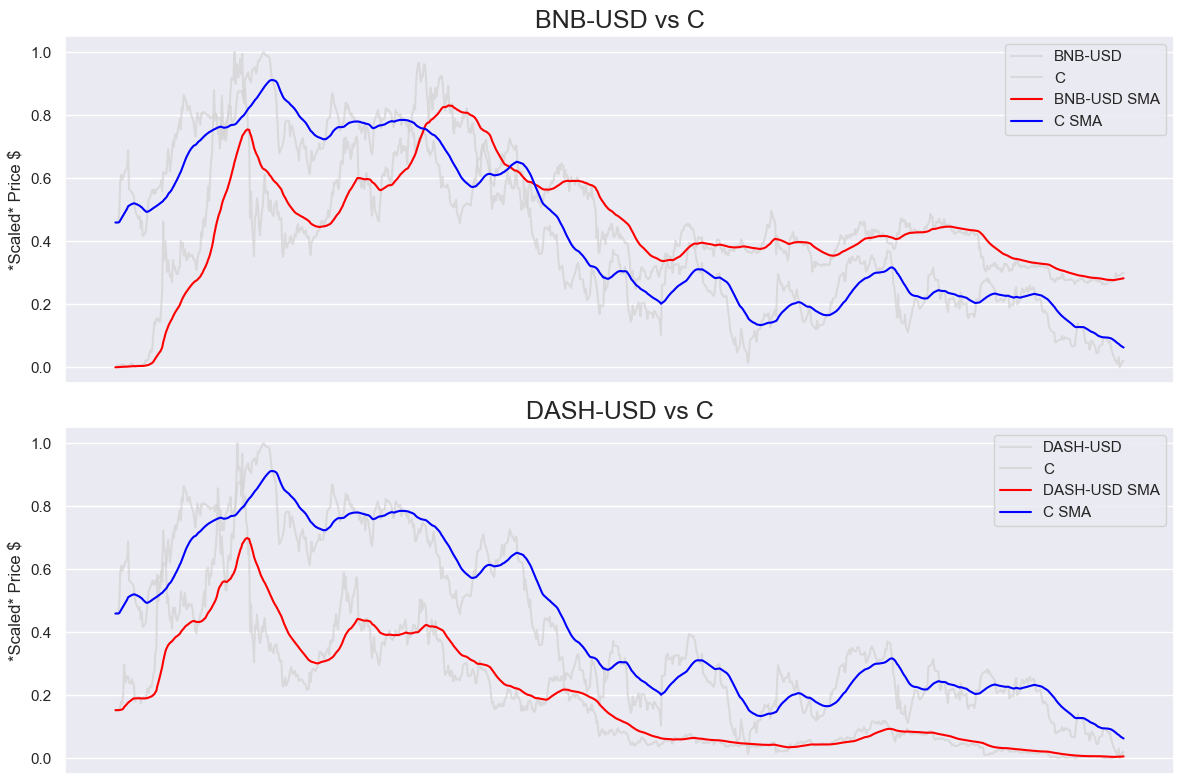

In [7]:
from sklearn.preprocessing import MinMaxScaler


# In order to compare both assets, even if they are of very different scales
# we need to normalize them
tickerPairs = [("BNB-USD", "C"), ("DASH-USD", "C")]
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
scaler = MinMaxScaler()
for i, (ticker1, ticker2) in enumerate(tickerPairs):
    # Scale the price data for each pair using MIN MAX
    scaledData1 = scaler.fit_transform(
        cleanData[ticker1]['Adj Close'].values.reshape(-1, 1))
    scaledData2 = scaler.fit_transform(
        cleanData[ticker2]['Adj Close'].values.reshape(-1, 1))
    axs[i].plot(scaledData1, label=f'{ticker1}', color='lightgray', alpha=0.7)
    axs[i].plot(scaledData2, label=f'{ticker2}', color='lightgray', alpha=0.7)


    # Compute exponential moving average with alpha = 0.04
    smoothData1 = pd.Series(scaledData1.reshape(-1)).ewm(alpha=0.04, adjust=False).mean()
    smoothData2 = pd.Series(scaledData2.reshape(-1)).ewm(alpha=0.04, adjust=False).mean()



    # Plot the exponential moving average of each ticker against the original price
    axs[i].plot(smoothData1, label=f'{ticker1} SMA', color='red')
    axs[i].plot(smoothData2, label=f'{ticker2} SMA', color='blue')
    axs[i].set_ylabel('*Scaled* Price $', fontsize=12)
    axs[i].set_title(f'{ticker1} vs {ticker2}', fontsize=18)
    axs[i].legend()
    axs[i].set_xticks([])
plt.tight_layout()
plt.show()

In [8]:
from TradingSystem import *
from Strategy import Strategy
from sklearn import linear_model

class PairTradingStrategy(Strategy):

    def regr(self, x, y):
        """
        Fit a linear regression model to the input data.

        Parameters:
        x (array-like): Independent variable data.
        y (array-like): Dependent variable data.

        Returns:
        array-like: Spread calculated as y - x * beta - alpha.
        """
        # Create a linear regression model
        regr = linear_model.LinearRegression()

        # Add a constant term to the independent variable
        x_constant = np.column_stack([np.ones(len(x)), x])

        # Fit the model to the data
        regr.fit(x_constant, y)

        # Get the coefficients and intercept from the model
        beta = regr.coef_[0]
        alpha = regr.intercept_

        # Calculate the spread as the difference between the dependent variable and the regression line
        spread = y - x * beta - alpha

        return spread

    def __init__(self, ticker1, ticker2, cleanData):
        """
        Initialize the PairTradingStrategy with the specified tickers and clean data.

        Parameters:
        ticker1 (str): Ticker symbol for the first asset.
        ticker2 (str): Ticker symbol for the second asset.
        cleanData (DataFrame): Cleaned data containing log returns for the assets.
        """
        super().__init__()
        
        self.ticker1 = ticker1
        self.ticker2 = ticker2
        self.cleanData = cleanData
        self.z_score_threshold = 1.0
        self.ema_alpha = 0.04

        # Get the log returns for the two assets
        self.scaledData1 = self.cleanData[self.ticker1]['log return']
        self.scaledData2 = self.cleanData[self.ticker2]['log return']
        
        # Create a DataFrame with the same index as the scaledData1
        index = self.scaledData1.index
        self.df = pd.DataFrame(index=index)
        
        # Calculate the spread between the two assets using the regr function
        self.df['spread'] = self.regr(self.scaledData1.values, self.scaledData2.values)
        
        # Calculate the mean and standard deviation of the spread
        self.mean = self.df['spread'].mean()
        self.std = self.df['spread'].std()
        self.zScore = (self.df['spread']- self.mean) / self.std

    def OnBar(self, verbose=False):
        """
        Execute the trading logic for each bar.

        Parameters:
        verbose (bool): Whether to print debug information. Default is False.

        Returns:
        None
        """
        size = 10

        # Calculate the ratio between the adjusted close prices of the two assets
        ratio = dataMap[self.ticker2]['Adj Close'][self.current_idx] / dataMap[self.ticker1]['Adj Close'][self.current_idx]
        
        # Check if the z-score is above the threshold
        if self.zScore[self.current_idx] > self.z_score_threshold:
            # Check if there is no existing position in the same direction
            if not self.portfolio.GetPositionSize(self.ticker1) > 0 and not self.portfolio.GetPositionSize(self.ticker2) < 0:
                # Buy the first asset and sell the second asset
                if(self.portfolio.GetPositionSize(self.ticker2)>0):
                    size = self.portfolio.GetPositionSize(self.ticker2)
                self.Buy(self.ticker1, size=size * ratio)
                self.Sell(self.ticker2, size=size)
        
        
        # Check if there is no existing position in the opposite direction
        if self.zScore[self.current_idx] < -self.z_score_threshold:
            if(self.portfolio.GetPositionSize(self.ticker1)>0):
                    size = self.portfolio.GetPositionSize(self.ticker1)
            if not self.portfolio.GetPositionSize(self.ticker1) < 0 and not self.portfolio.GetPositionSize(self.ticker2) > 0:
                self.Buy(self.ticker2, size=size/ratio )
                self.Sell(self.ticker1, size=size)

100%|██████████| 711/711 [00:00<00:00, 28030.89it/s]


Starting Portfolio Value: 10000.00
Final Portfolio Value: 13008.10
ROI 30.08100294020517
Annualized Volatility 0.10682857711266246
Max Drawdown -0.11265705357515382
Annualized Sharpe 0.9262683573712799


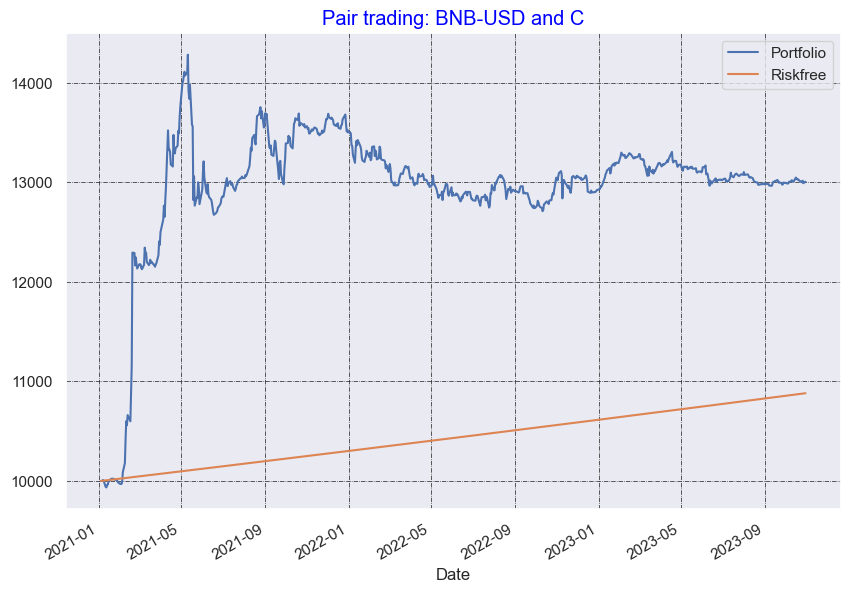

In [9]:
tickers= ["BNB-USD", "C"]
# Initialize the trading system
trader = TradingSystem()
# Add the Apple data to the trading system
for ticker in tickers:
    trader.AddCleanData(ticker, dataMap[ticker])


# Set the strategy of the trading system to a naive strategy
# where we buy on one day and sell on the next day
trader.SetStrategy(PairTradingStrategy(tickers[0], tickers[1],cleanData))
# The portfolio starts with $10000 
trader.portfolio.SetInitialCash(10000)


 
 # Perform a backtest for the basic trading strategy  
trader.Run()




print('Starting Portfolio Value: %.2f' % trader.portfolio.initialCash)
print('Final Portfolio Value: %.2f' % trader.GetPortfolioValue())


# Analyze the backtest by providing various statistics
trader.GetStats()
pairLog = trader.log['Portfolio']
trader.log.plot(figsize=(10,7))
plt.title("Pair trading: BNB-USD and C",size='large',color='blue')
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

### Adding transaction costs
We now add transaction costs to the model. Using ```trader.SetTransactionCost(transaction_rate)```, a percentage of every trade(both buy and sell) is subtracted from the portfolio cash. This reduces the performance of the pairs strategy significantly.

100%|██████████| 711/711 [00:00<00:00, 17527.01it/s]


Starting Portfolio Value: 10000.00
Final Portfolio Value: 13008.10
ROI 12.192296841072947
Annualized Volatility 0.10848687723311634
Max Drawdown -0.2031108770251466
Annualized Sharpe 0.4296725771875413


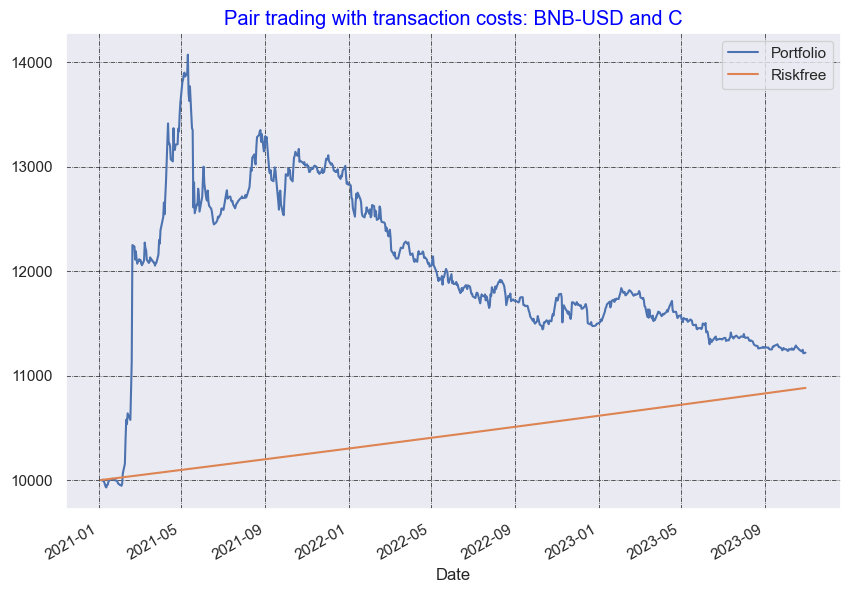

In [10]:

# Initialize the trading system
trader_with_transaction_cost = TradingSystem()
# Add the Apple data to the trading system
for ticker in tickers:
    trader_with_transaction_cost.AddCleanData(ticker, dataMap[ticker])


# Set the strategy of the trading system to a naive strategy
# where we buy on one day and sell on the next day
trader_with_transaction_cost.SetStrategy(PairTradingStrategy(tickers[0], tickers[1],cleanData))
# The portfolio starts with $10000 
trader_with_transaction_cost.portfolio.SetInitialCash(10000)
# Set the transaction cost
trader_with_transaction_cost.SetTransactionCost(0.005)


 
 # Perform a backtest for the basic trading strategy  
trader_with_transaction_cost.Run()




print('Starting Portfolio Value: %.2f' % trader.portfolio.initialCash)
print('Final Portfolio Value: %.2f' % trader.GetPortfolioValue())
# PlotStockData(ticker, (trader.datas[ticker])['Adj Close'])


# Analyze the backtest by providing various statistics
trader_with_transaction_cost.GetStats()
pair_with_transaction_costLog = trader.log['Portfolio']
trader_with_transaction_cost.log.plot(figsize=(10,7))
plt.title("Pair trading with transaction costs: BNB-USD and C",size='large',color='blue')
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

The pair strategy beats the risk-free rate (which we set to 3%). Next we compare it to the S&P 500.

[*********************100%%**********************]  1 of 1 completed
100%|██████████| 711/711 [00:00<00:00, 74879.48it/s]

Starting Portfolio Value: 10000.00
Final Portfolio Value: 13008.10
ROI 16.33660034179687
Annualized Volatility 0.17712247679434442
Max Drawdown -0.24275592942986232
Annualized Sharpe 0.3917663276978763


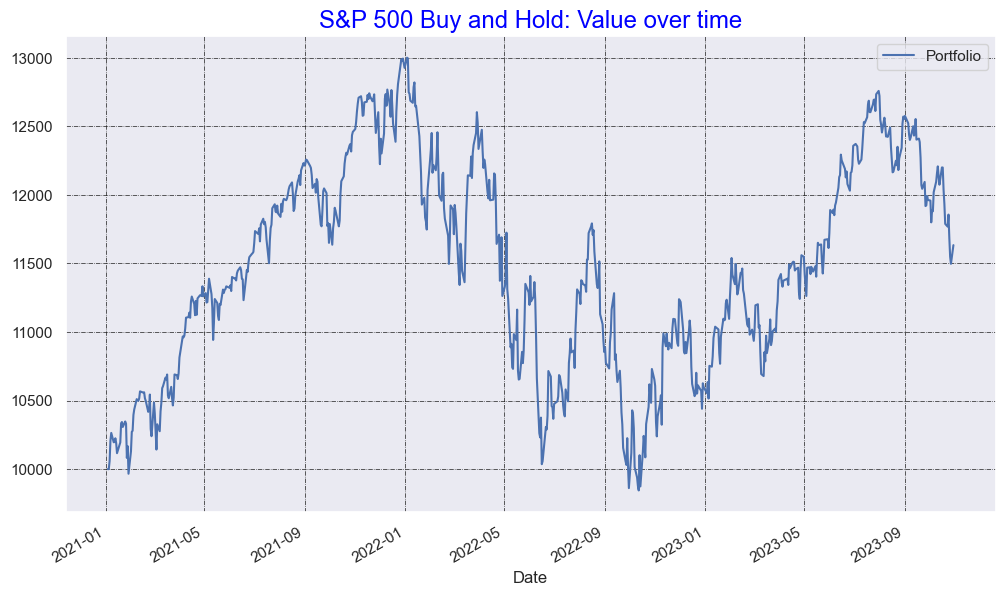

In [11]:


# Load SPY data in the same time span 
ticker = 'SPY'
startDate = '2021-01-01'
endDate = '2023-10-31'



# Initialize the trading system
trader_SPY = TradingSystem()
# Add the Apple data to the trading system
trader_SPY.DownloadData(ticker, startDate, endDate)
# Set the strategy of the trading system to a naive strategy
# where we buy on one day and sell on the next day
trader_SPY.SetStrategy(BuyAndHold())
# The portfolio starts with $10000 
trader_SPY.portfolio.SetInitialCash(10000)


 
 # Perform a backtest for the basic trading strategy  
trader_SPY.Run()




print('Starting Portfolio Value: %.2f' % trader.portfolio.initialCash)
print('Final Portfolio Value: %.2f' % trader.GetPortfolioValue())


# Analyze the backtest by providing various statistics
trader_SPY.GetStats()
spyLog = trader_SPY.log['Portfolio']

# Plot the portfolio value
trader_SPY.log[['Portfolio']].plot(figsize=(12,7))
plt.title("S&P 500 Buy and Hold: Value over time",size='x-large',color='blue')
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()


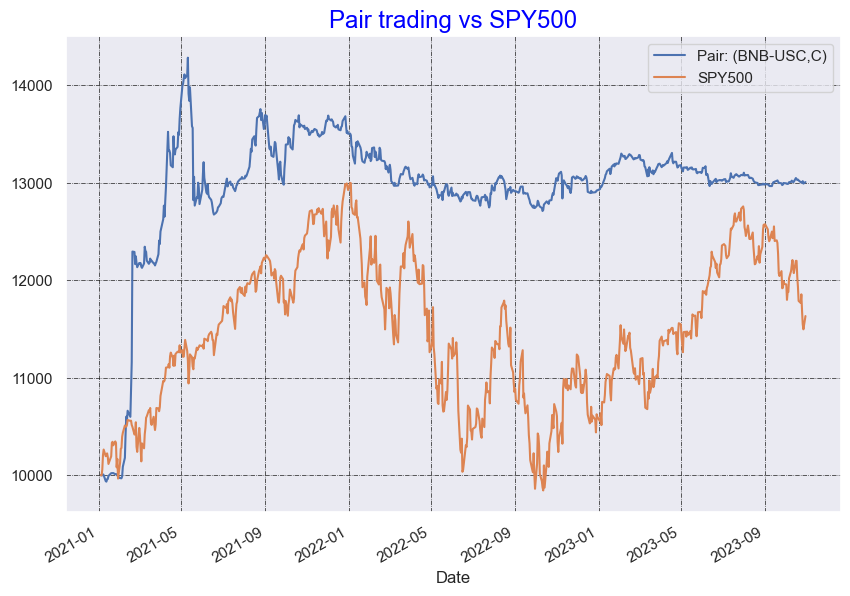

In [12]:
# Compare the pairs strategy to SPY 500

df = pd.DataFrame(index = pairLog.index)
df['Pair: (BNB-USC,C)'] = pairLog
df['SPY500'] = spyLog
df.plot(figsize=(10,7))
plt.title("Pair trading vs SPY500",size='x-large',color='blue')
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.legend()
plt.show()